# Notebook 4. Modelling

## Imports and data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
DATAFILE = '../data/reddit_cleaned.csv'
df_all = pd.read_csv(DATAFILE, index_col = 'id')
df = df_all.sample(1000000).copy()
# df = df_all.copy()

In [3]:
df.head()
df.columns
df.info()
# Filling in empty cells for selftext field
df['selftext'].fillna('notextprovided', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, ljecdy to mhegxj
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   author               1000000 non-null  object 
 1   created              1000000 non-null  object 
 2   removed              1000000 non-null  int64  
 3   deleted              1000000 non-null  int64  
 4   is_self              1000000 non-null  int64  
 5   is_video             1000000 non-null  int64  
 6   title                999995 non-null   object 
 7   link_flair_text      1000000 non-null  object 
 8   upvote_ratio         1000000 non-null  float64
 9   score                1000000 non-null  int64  
 10  num_comments         1000000 non-null  int64  
 11  selftext             693244 non-null   object 
 12  shortlink            1000000 non-null  object 
 13  FolderName           1000000 non-null  object 
 14  word_count_selftext  1000000 non-null  int64  
 15 

In [4]:
df.columns
df = df.drop(['author', 'created',
       'title', 'link_flair_text', 
       'selftext', 'shortlink', 'FolderName', 'date'], axis=1)

In [5]:
df.describe()

,removed,deleted,is_self,is_video,upvote_ratio,score,num_comments,word_count_selftext,word_count_title
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.660831,0.091341,0.633480,0.020277,0.886856,85.354271,11.827142,35.512105,9.974424
std,0.473428,0.288094,0.481854,0.140946,0.189171,1643.976009,312.483619,143.024597,8.524559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.830000,1.000000,0.000000,1.000000,4.000000
50%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,7.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,6.000000,6.000000,1.000000,13.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,299489.000000,96694.000000,14410.000000,143.000000


In [6]:
df.isna().sum()/df.shape[0]

removed                0.0
deleted                0.0
is_self                0.0
is_video               0.0
upvote_ratio           0.0
score                  0.0
num_comments           0.0
word_count_selftext    0.0
word_count_title       0.0
dtype: float64

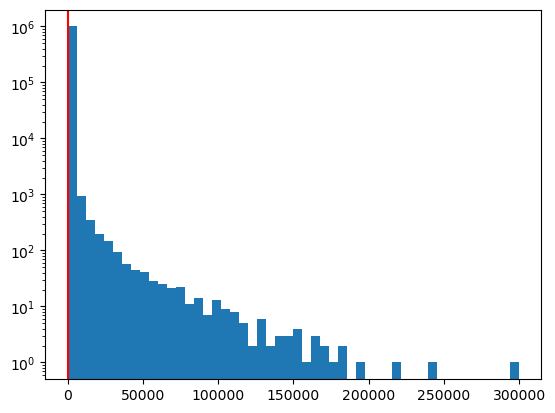

In [7]:
plt.hist(df['score'], bins = 50)
plt.axvline(df['score'].mean(), color = 'r')
plt.yscale('log');

In [8]:
df.corr()['score'].sort_values()

removed               -0.054810
is_self               -0.037274
deleted               -0.011508
upvote_ratio           0.013931
word_count_title       0.014392
word_count_selftext    0.015975
is_video               0.048835
num_comments           0.272794
score                  1.000000
Name: score, dtype: float64

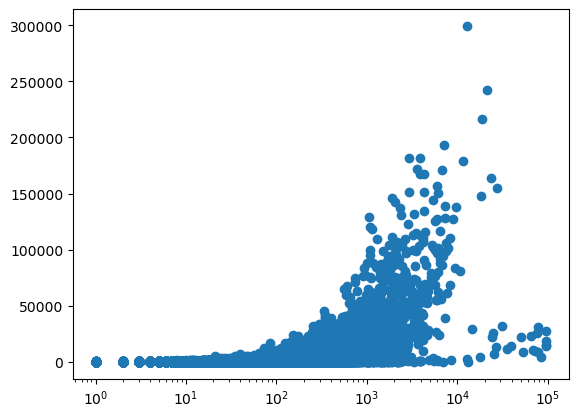

In [9]:
plt.scatter(df['num_comments'], df['score'])
plt.xscale('log')

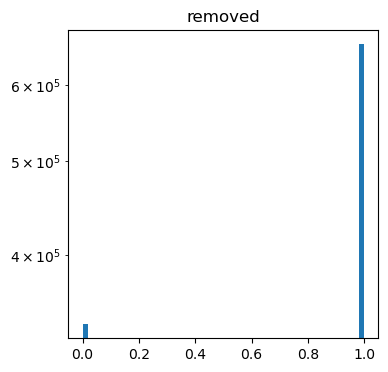

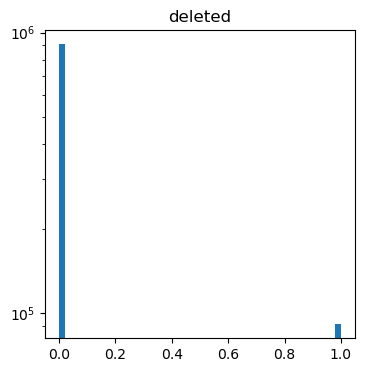

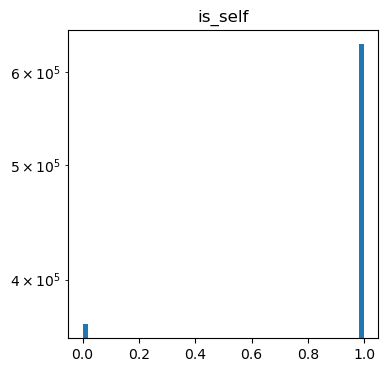

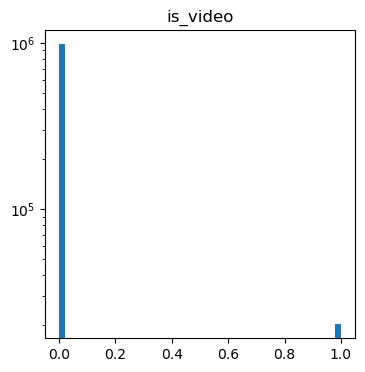

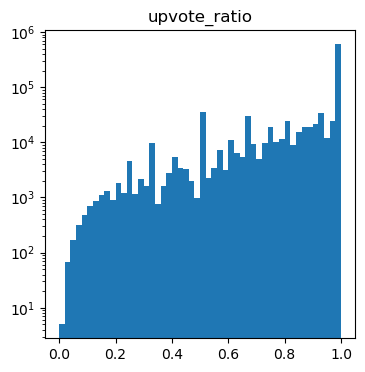

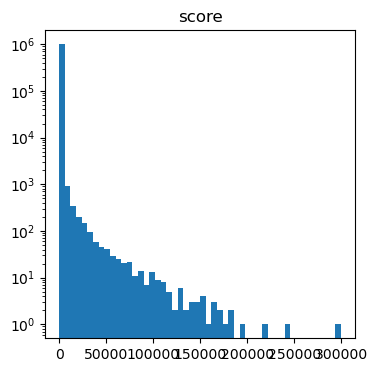

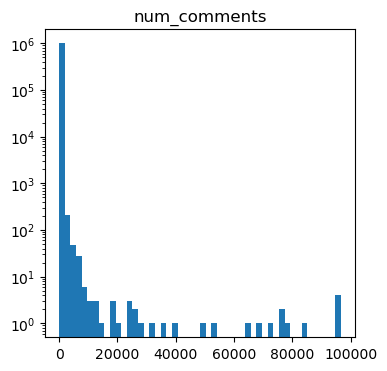

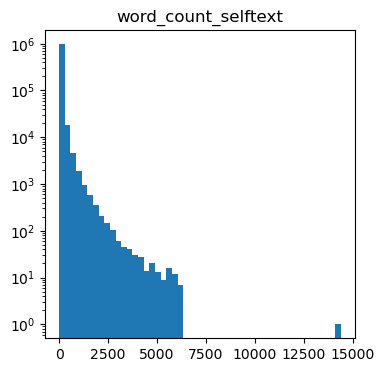

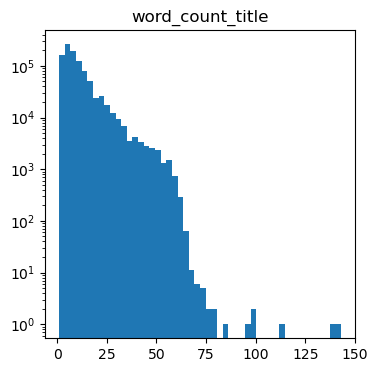

In [10]:
for column in df.columns:
    plt.figure(figsize=(4, 4))  # Set the figure size to 4x4 inches
    plt.hist(df[column], bins=50)
    plt.title(column)
    plt.yscale('log')
    plt.show()

Many features show a strong skew towards 0, and outliers will tend to skew distance based models. I do a log transform to make these distributions more normal.

In [11]:
df2 = np.log(df + 1)

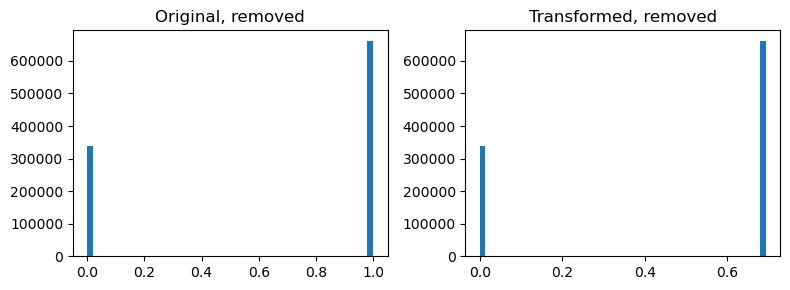

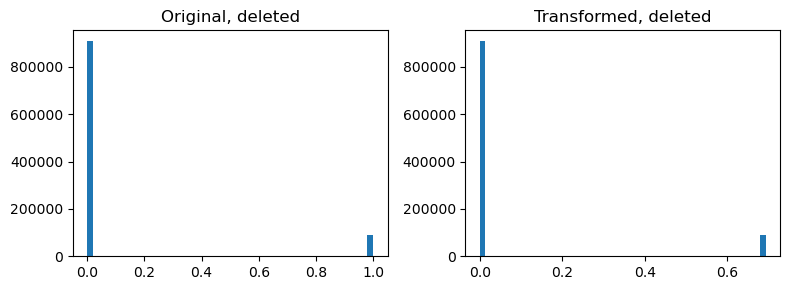

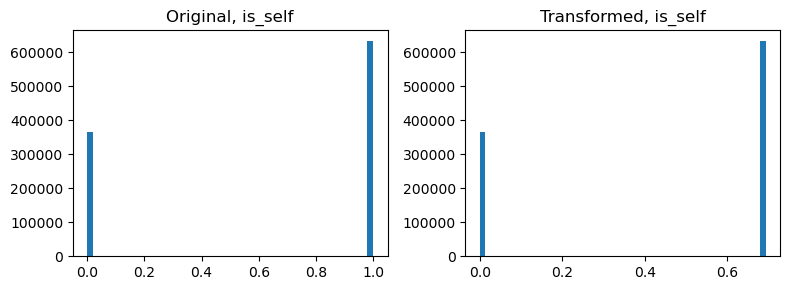

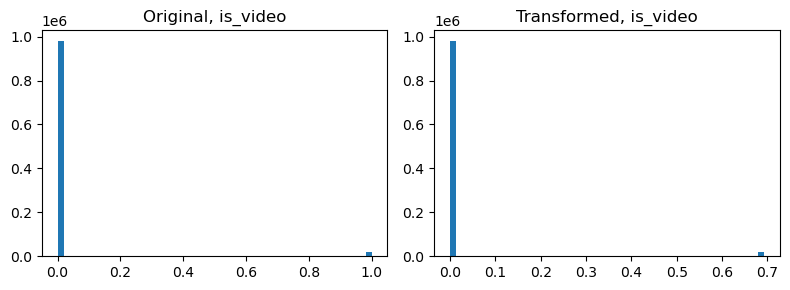

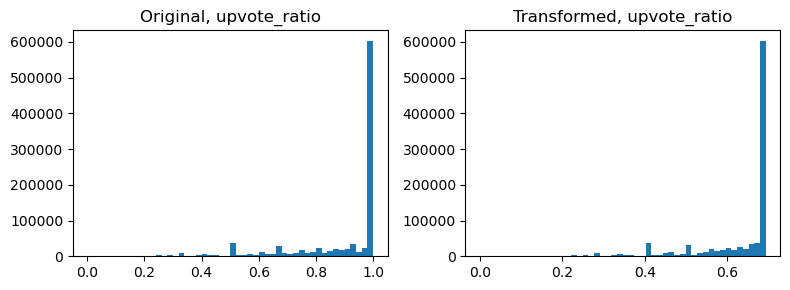

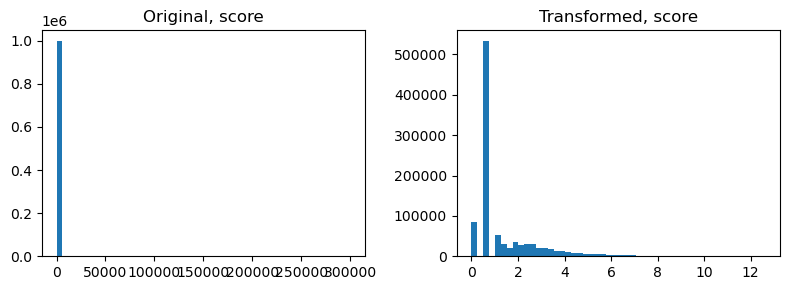

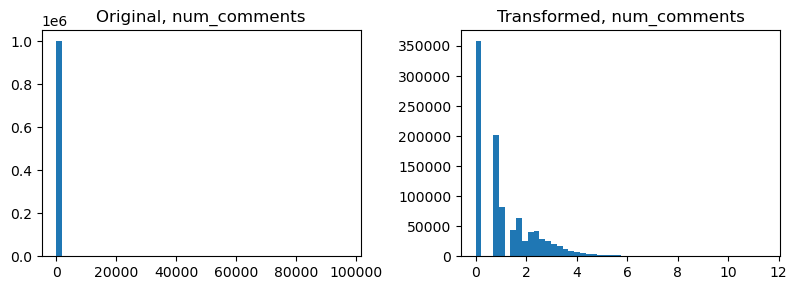

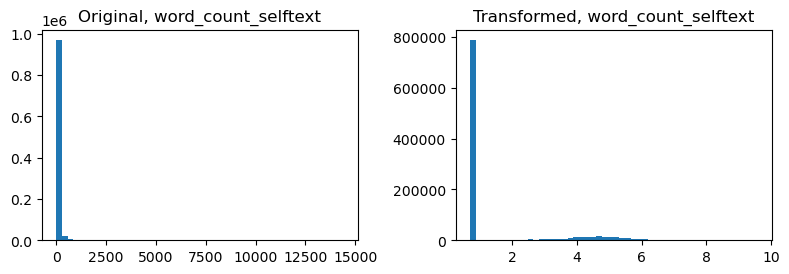

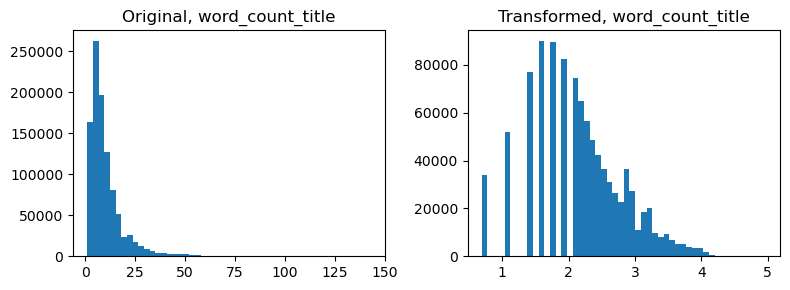

In [12]:
for column in df2.columns:
  plt.subplots(1,2, figsize = (8, 3))

  plt.subplot(1, 2, 1)
  plt.title(f"Original, {column}")
  plt.hist(df[column], bins = 50)

  plt.subplot(1, 2, 2)
  plt.title(f"Transformed, {column}")
  plt.hist(df2[column], bins = 50)

  plt.tight_layout()
  plt.show()

The log transform has had very little effect on the categorical one hot encoded columns.  The numerical abnormally distributed columns have all been transformed into distributions that are more normal, allowing for fairer comparisons of distances later in modeling.

In [13]:
my_scaler = StandardScaler()
X = my_scaler.fit_transform(df2)
df_scaled = pd.DataFrame(X, columns = df2.columns)

## Clustering

In [14]:
pca = PCA(n_components = 5)
pca_data = pca.fit_transform(df_scaled)

In [15]:
pca.explained_variance_ratio_

array([0.29931501, 0.17966702, 0.12693807, 0.11046362, 0.09401279])

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x800 with 0 Axes>

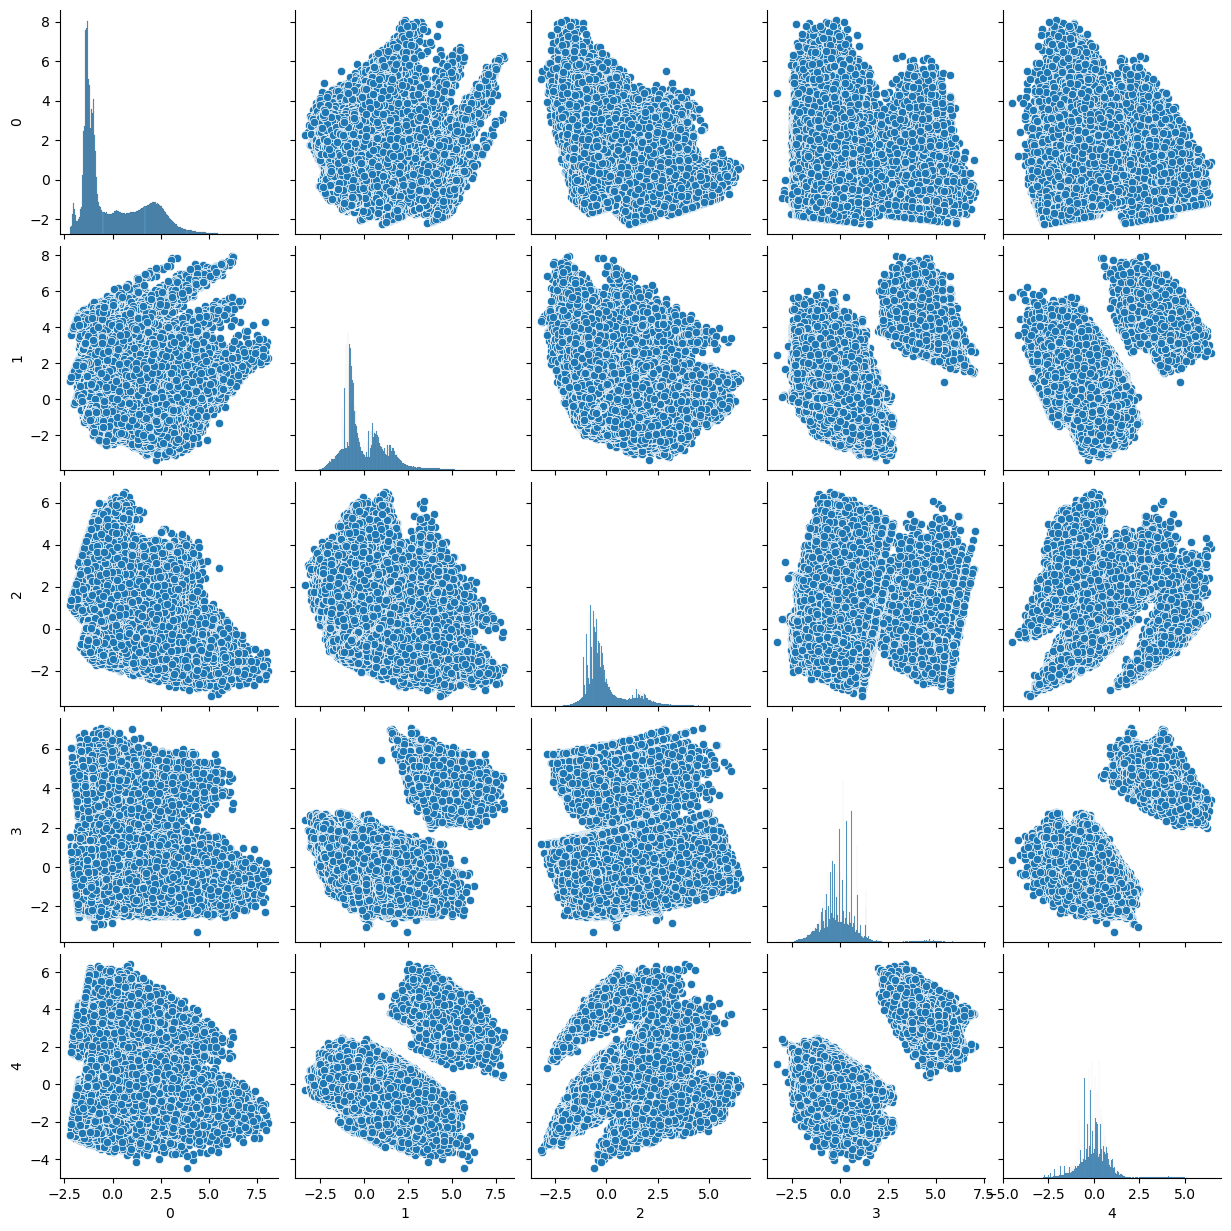

In [16]:
plt.figure(figsize = (8, 8))
sns.pairplot(pd.DataFrame(pca_data))

t-SNE is a visualisation technique that ignores all information / variance in the dataset, and only preserves the relative positions of data points.

In [17]:
# Runtime = 1m 23s seconds for 50000 sample 

sample = df_scaled.sample(frac = 0.1, random_state = 1)

tsne = TSNE(n_components = 3, random_state = 1, verbose = 1)
tsne_data = tsne.fit_transform(sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.033s...
[t-SNE] Computed neighbors for 100000 samples in 11.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probab

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


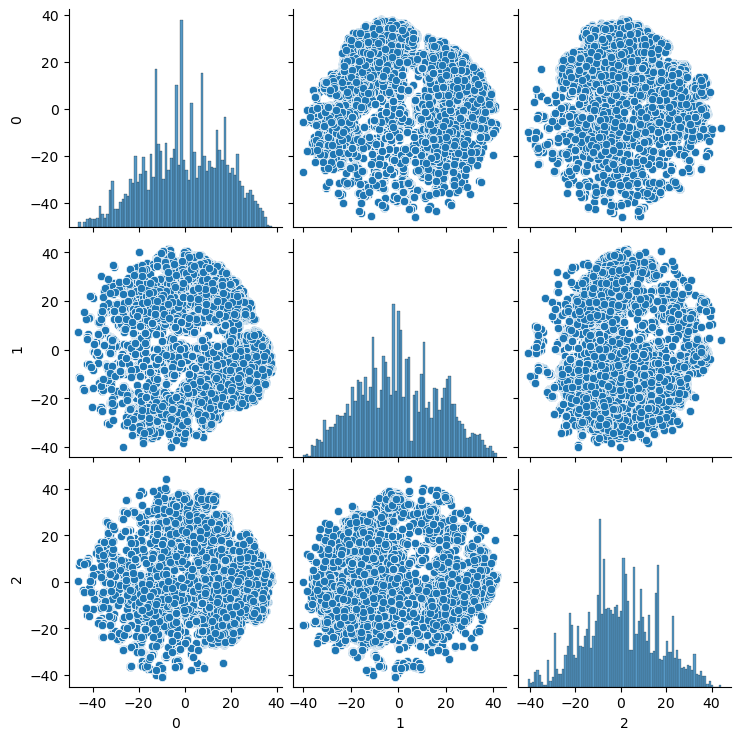

In [18]:
sns.pairplot(pd.DataFrame(tsne_data))

Observation:
* Data points that were close together in XX(many) -dimensional space, are still close together in the new 3-dimensional space.
* There is one large blob, and one very small blob

## KMeans

In [ ]:
# Runtime is very long - 2m 30 sec for 5000 rows

inertias = []
silhouettes = []
k_range = np.arange(2, 11)

for k in k_range:
  print("In progress: K = ", k)
  my_kmeans = KMeans(n_clusters = k)
  my_kmeans.fit(df_scaled)
  labels = my_kmeans.predict(df_scaled)

  inertias.append(my_kmeans.inertia_)
  silhouettes.append(silhouette_score(df_scaled, labels))

Let's visualise our inertias in a Scree Plot

In [ ]:
plt.figure()
plt.plot(k_range, inertias, marker = 'o')
plt.xlabel("Nr clusters")
plt.ylabel("Inertia")
plt.show()

There is no obvious elbow point, after which adding more clusters has very little effect.
Let's use our silhouette scores as a second opinion.

In [ ]:
plt.figure()
plt.plot(k_range, silhouettes, marker='o')
plt.xlabel('Nr clusters')
plt.ylabel('Silhouette score')
plt.show()

Purely based on silhouette scores, where bigger is better, we would be tempted to try 5 clusters, but let's explore other options.

# KMeans with 4 clusters

In [ ]:
# Runtime 1m47s for 5000 sample

# cluster the data
kmeans = KMeans(n_clusters = 2)
labels = kmeans.fit_predict(df_scaled)

# add labels to original dataframe
df_kmeans = df_scaled.copy()
df_kmeans['labels'] = labels

# visualise with t-sne
sample = df_kmeans.sample(frac = 0.4, random_state = 1)
tsne = TSNE(n_components = 3, verbose=1, random_state = 1)
tsne_data = tsne.fit_transform(sample.drop('labels', axis = 1))

# rebuilt a dataframe
tsne_df = pd.DataFrame(tsne_data, columns = [f"tsne D {i}" for i in range(tsne_data.shape[1])])
tsne_df['labels'] = sample['labels'].values

# Pairplot
sns.pairplot(data = tsne_df, hue='labels')


In [ ]:
# Runtime 1m 45 sec for 5000 samples

# cluster the data
kmeans = KMeans(n_clusters = 3)
labels = kmeans.fit_predict(df_scaled)

# add labels to original dataframe
df_kmeans = df_scaled.copy()
df_kmeans['labels'] = labels

# visualise with t-sne
sample = df_kmeans.sample(frac = 0.4, random_state = 1)
tsne = TSNE(n_components = 3, verbose=1, random_state = 1)
tsne_data = tsne.fit_transform(sample.drop('labels', axis = 1))

# rebuilt a dataframe
tsne_df = pd.DataFrame(tsne_data, columns = [f"tsne D {i}" for i in range(tsne_data.shape[1])])
tsne_df['labels'] = sample['labels'].values

# Pairplot
sns.pairplot(data = tsne_df, hue='labels')

## DBSCAN

In [ ]:
# Runtime = 13 minutes for 50000 samples
silhouettes = []
num_clusters = []
epsilons = np.arange(1, 3, 0.1)

for eps in epsilons:
  model = DBSCAN(eps = eps, min_samples = 50)
  labels = model.fit_predict(df_scaled)

  n_clusters = len(np.unique(labels[labels != -1]))
  num_clusters.append(n_clusters)

  print(f"Eps: {eps}, N_clusters = {n_clusters}")

  silhouettes.append(silhouette_score(df_scaled, labels))

At very small values for epsilon, clusters can't reach far enough to the next data point, and many small clusters emerge.

At large values of epsilon, all data points are gobbled up by a single cluster

Values of epsilon to look at more closely are 2.1, resulting in 5 clusters, or 2.2 resulting in 2 clusters.

In [ ]:
dbscan_model = DBSCAN(eps=2.2, min_samples=100)
dbscan_y_labels = dbscan_model.fit_predict(df_scaled)


cc_df_dbscan = df_scaled.copy()
cc_df_dbscan['dbscan_labels'] = dbscan_y_labels


sample = cc_df_dbscan.sample(frac=0.4, random_state=1)

tsne = TSNE(n_components=3, verbose=2, random_state=1)

# We need to drop the labels so tSNE won't use them when computing distances
tsne_data = tsne.fit_transform(sample.drop('dbscan_labels', axis=1))

tsne_df = pd.DataFrame(tsne_data, columns=[f'tSNE D{i+1}' for i in range(tsne_data.shape[1])])
tsne_df['dbscan_labels'] = sample['dbscan_labels'].values.astype(str)
tsne_df

In [ ]:
sns.pairplot(tsne_df, hue="dbscan_labels", plot_kws={'alpha': 0.5})
plt.show()

DBSCAN seems to have assigned almost all data points to the same cluster. The data set doesn't contain sparse regions between denser regions and hence DBSCAN wasn't able delineate between clusters.

## Hierarchical clustering

In [ ]:
# Look at a dendogram for hierarchical
from scipy.cluster.hierarchy import linkage, dendrogram

# Use Ward
linkage_mat = linkage(df_scaled, 'ward')

# Look at scoring as well
plt.figure(figsize=(15,10))
dendrogram(linkage_mat)
plt.xticks([])
plt.show()

The dendrogram shows that two groups are easily separated, but more seems difficult

In [ ]:
# Try different clustering for agglomerative

ks = np.arange(2, 11)
silhouette_list = []

for k in ks:

    # Instantiate
    my_hclust = AgglomerativeClustering(n_clusters=k, linkage='ward')

    # Fit
    y_labels = my_hclust.fit_predict(df_scaled)

    # Calculate score
    silhouette = silhouette_score(df_scaled, y_labels)
    silhouette_list.append(silhouette)
    print(f"Computed Score for k={k}")

In [ ]:
plt.figure()
plt.plot(ks, silhouette_list, marker='o')
plt.xlabel('K - number of clusters')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

## Comparing the Found Groups

We now need to explore the clusters. We will look at:
- How similar are the results for the different clustering algorithms?
- For each clustering result, what are the main differences between the found groups?
- Are the found groups statistically different from each other?
- Based on the exploration of the clusters, what are the characteristics of each group? Do they represent some type of customer?

In [ ]:
kmeans_final = KMeans(n_clusters = 2)

final_labels = kmeans_final.fit_predict(df_scaled)

In [ ]:
df_final = df_scaled.copy()
df_final['KMeans_cluster'] = final_labels

In [ ]:
df_final.head()

Let's start by exploring the means of each column for cluster 0 vs cluster 1

In [ ]:
relative_means = df_final.groupby('KMeans_cluster').mean()
relative_means

In [ ]:
sns.boxplot(data = df_final, x = 'KMeans_cluster', y='score');

In [ ]:
melted_means = relative_means.reset_index().melt(id_vars='KMeans_cluster')

In [ ]:
sns.barplot(data = melted_means, x= 'value', y= 'variable', hue = 'KMeans_cluster');

Observations:
Commonalities: Both clusters have comparable credit limits, payment amounts, balance frequency, but the clusters split apart on the following characteristics:

Blue:
- Loves ATM withdrawals (cash advance, TRX, FREQ)
- Almost never use their card for One-off or installment purchases, both in frequency and overall amount
- Tend to have repaid less of their loan, tend to have higher minimum payments, and have had their card for slightly shorter.

Orange:
- Tend to use their card more for one-off and installment purchases, tend to have lower balances, and are faster at repaying their debt.

### Characteristics (based on hierarchical clustering)

In [ ]:
final_hier = AgglomerativeClustering(n_clusters = 4, linkage = 'ward')
hier_labels = final_hier.fit_predict(df_scaled)

In [ ]:
df_final['hierarchical_clusters'] = hier_labels

In [ ]:
df_final.head()

In [ ]:
pd.crosstab(df_final['KMeans_cluster'], df_final['hierarchical_clusters'])

In [ ]:
relative_means = df_final.groupby('hierarchical_clusters').mean()

melted_means = relative_means.reset_index().melt(id_vars='hierarchical_clusters')
sns.barplot(data = melted_means, x= 'value', y= 'variable', hue = 'hierarchical_clusters');

### Characteristics (based on kmeans clustering)

## Findings

How would you describe the found groups? What kind of value proposition can this clustering provide?

We have identified two groups of customers: one group that prefers to use cash, and primarily uses their credit card to withdraw cash. They rarely make use of payment plans. Perhaps they like to feel more in control of their finances.
We would want to incentivise these people to use their card in shops, where we can collect a transaction fee.


